# Telco Customer Churn - Modeling


### 01. Import Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc, recall_score, precision_score, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

### 02. Load Processed Data

In [3]:
train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Seperate features and target
target = 'Churn'
X_train_ber_res = train_df.drop(target, axis=1)
y_train_ber_res = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

Train shape: (5634, 50)
Test shape: (1409, 50)


In [4]:
# --- Input/Output Data Inspection ---
print("Shape of Training Features (X_train_ber_res):", X_train_ber_res.shape)
print("Shape of Training Target (y_train_ber_res):", y_train_ber_res.shape)
print("Shape of Test Features (X_test):", X_test.shape)
print("Shape of Test Target (y_test):", y_test.shape)

print("\nFirst 5 rows of Input Features:")
display(X_train_ber_res.head())

print("\nFirst 5 rows of Target Labels (0 = No Churn, 1 = Churn):")
display(y_train_ber_res.head())

Shape of Training Features (X_train_ber_res): (5634, 49)
Shape of Training Target (y_train_ber_res): (5634,)
Shape of Test Features (X_test): (1409, 49)
Shape of Test Target (y_test): (1409,)

First 5 rows of Input Features:


,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureCategory_Established,TenureCategory_Loyal,TenureCategory_New
0,0.102371,-0.521976,-0.262257,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,-0.711743,0.337478,-0.503635,0,1,1,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
2,-0.793155,-0.809013,-0.749883,0,1,1,0,0,1,0,...,1,1,0,0,0,0,1,1,0,0
3,-0.263980,0.284384,-0.172722,1,0,1,0,0,1,1,...,1,0,1,0,1,0,0,1,0,0
4,-1.281624,-0.676279,-0.989374,0,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1



First 5 rows of Target Labels (0 = No Churn, 1 = Churn):


0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

### 03. Class Imbalance Handling 
Applied **SMOTE** once to the training set to create a balanced dataset for all models

Original Class Distribution: Counter({0: 4139, 1: 1495})
Resampled Class Distribution: Counter({0: 4139, 1: 4139})


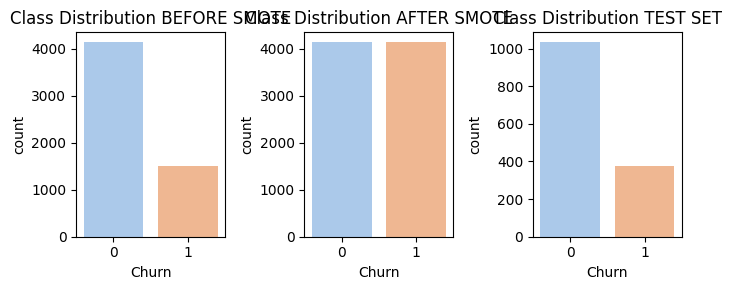

In [5]:
print("Original Class Distribution:", Counter(y_train_ber_res))

# Apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = smote.fit_resample(X_train_ber_res, y_train_ber_res)

print("Resampled Class Distribution:", Counter(y_train))

# Visualization
plt.figure(figsize=(7, 3))
plt.subplot(1, 3, 1)
sns.countplot(x=y_train_ber_res, palette='pastel')
plt.title('Class Distribution BEFORE SMOTE')
plt.subplot(1, 3, 2)
sns.countplot(x=y_train, palette='pastel')
plt.title('Class Distribution AFTER SMOTE')
plt.subplot(1, 3, 3)
sns.countplot(x=y_test, palette='pastel')
plt.title('Class Distribution TEST SET')
plt.tight_layout()
plt.savefig('../artifacts/images/smote_class_distribution.png')
plt.show()

### 04. Model Development

- logistic regression
- decision tree
- random forest
- XGBoost
- CatBoost


In [6]:
models = { 
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeClassifier(),
    'RandomForest' : RandomForestClassifier(),
    'XGBoost' : XGBClassifier(),
    'CatBoost' : CatBoostClassifier(),
}

# Use the Decision Tree instance to get the cost-complexity pruning path
DTpath = models['Decision Tree'].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = DTpath.ccp_alphas[DTpath.ccp_alphas >= 0]



# Advanced Hyper param Tuning - It Takes long time 
"""
params = {
    'Logistic Regression' : {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse regularization strength
            'solver': ['liblinear', 'saga', 'lbfgs'], # liblinear for L1, saga for elasticnet
            'max_iter': [100, 200, 500]
        },
    'Decision Tree' : {
            'ccp_alpha': list(ccp_alphas[::20]),
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        },
    'RandomForest' : {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        },
    'XGBoost' : {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2]
        },
    'CatBoost' : {
            'iterations': [100, 500, 1000],
            'learning_rate': [0.01, 0.05, 0.1],
            'depth': [4, 6, 8, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'border_count': [32, 64, 128]
        }
} 
"""

"\nparams = {\n    'Logistic Regression' : {\n            'penalty': ['l1', 'l2', 'elasticnet'],\n            'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse regularization strength\n            'solver': ['liblinear', 'saga', 'lbfgs'], # liblinear for L1, saga for elasticnet\n            'max_iter': [100, 200, 500]\n        },\n    'Decision Tree' : {\n            'ccp_alpha': list(ccp_alphas[::20]),\n            'criterion': ['gini', 'entropy'],\n            'max_depth': [None, 5, 10, 15, 20],\n            'min_samples_split': [2, 5, 10],\n            'min_samples_leaf': [1, 2, 4],\n            'max_features': ['sqrt', 'log2', None]\n        },\n    'RandomForest' : {\n            'n_estimators': [100, 200, 300],\n            'max_depth': [10, 20, 30, None],\n            'min_samples_split': [2, 5, 10],\n            'min_samples_leaf': [1, 2, 4],\n            'bootstrap': [True, False]\n        },\n    'XGBoost' : {\n            'n_estimators': [100, 200],\n            'learning_rate

In [7]:
# Simple param list for faster training
params = {
    'Logistic Regression' : {
            'penalty': ['l2'],
            'C': [0.1],  # Inverse regularization strength
            'solver': ['saga'], # liblinear for L1, saga for elasticnet
            'max_iter': [100]
        }, # {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
    'Decision Tree' : {
            'ccp_alpha': list(ccp_alphas[::20]),
            'criterion': ['gini'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': [None]
        }, # ccp_alpha': np.float64(0.0004080529258828139), 'criterion': 'gini', 'max_depth': 15,
           # 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
    'RandomForest' : {
            'n_estimators': [300],
            'max_depth': [30],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'bootstrap': [False]
        }, # 'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1,
           # 'min_samples_split': 2, 'n_estimators': 300}
    'XGBoost' : {
            'n_estimators': [100],
            'learning_rate': [0.05],
            'max_depth': [9],
            'subsample': [1.0],
            'colsample_bytree': [0.6],
            'gamma': [0.2]
        }, # {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.05,
           #  'max_depth': 9, 'n_estimators': 100, 'subsample': 1.0}
    'CatBoost' : {
            'iterations': [100],
            'learning_rate': [0.05],
            'depth': [10],
            'l2_leaf_reg': [1],
            'border_count': [32]
        }  # {'border_count': 32, 'depth': 10, 'iterations': 100,
           # 'l2_leaf_reg': 1, 'learning_rate': 0.05}
}

In [8]:
results = {}
best_models = {}

print("Training and Tuning Classification Models...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    print(f"\nProcessing {name}...")
    
        
    # K-Fold CV (Baseline)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"  Baseline CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    # GridSearchCV
    if params[name]:
        print(f"  Tuning {name}...")
        grid = GridSearchCV(model, params[name], cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"  Best Params: {grid.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        
    best_models[name] = best_model
    
    # Evaluate on Test Set
    preds = best_model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    
    results[name] = {
        'CV Mean Accuracy': cv_scores.mean(),
        'Test Accuracy': acc, 
        'Test F1-Score': f1
    }
    print(f"  Test Accuracy: {acc:.4f}, Test F1-Score: {f1:.4f}")

Training and Tuning Classification Models...

Processing Logistic Regression...
  Baseline CV Accuracy: 0.8506 (+/- 0.0089)
  Tuning Logistic Regression...
  Best Params: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
  Test Accuracy: 0.7757, Test F1-Score: 0.7804

Processing Decision Tree...
  Baseline CV Accuracy: 0.7915 (+/- 0.0073)
  Tuning Decision Tree...
  Best Params: {'ccp_alpha': np.float64(0.00040770717564629145), 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Test Accuracy: 0.7466, Test F1-Score: 0.7556

Processing RandomForest...
  Baseline CV Accuracy: 0.8636 (+/- 0.0061)
  Tuning RandomForest...
  Best Params: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
  Test Accuracy: 0.7665, Test F1-Score: 0.7650

Processing XGBoost...
  Baseline CV Accuracy: 0.8521 (+/- 0.0059)
  Tuning XGBoost...
  Best Params: {'colsample_bytree': 0.6, 'gamma

### 05. Treshold Tuning

--- Logistic Regression ---
Logistic Regression -> Best Threshold: 0.4588, Max F1: 0.6349


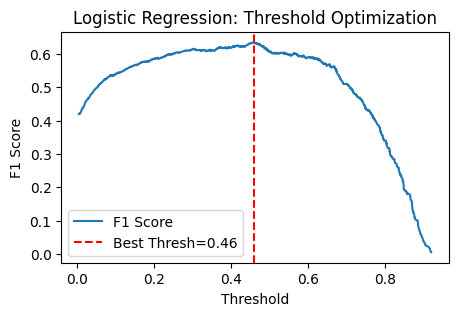

0.4587524119438497
--- Decision Tree ---
Decision Tree -> Best Threshold: 0.2963, Max F1: 0.5913


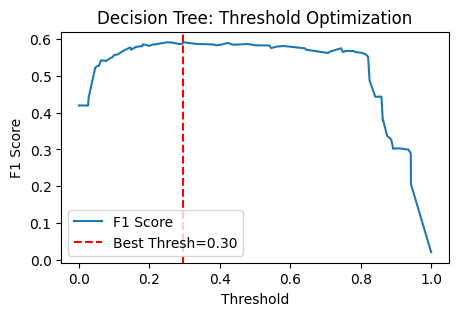

0.2962962962962963
--- RandomForest ---
RandomForest -> Best Threshold: 0.2833, Max F1: 0.5985


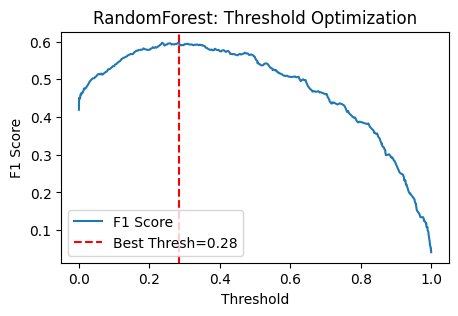

0.2833333333333333
--- XGBoost ---
XGBoost -> Best Threshold: 0.2864, Max F1: 0.6125


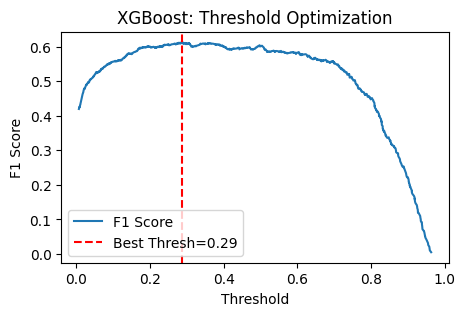

0.28644753
--- CatBoost ---
CatBoost -> Best Threshold: 0.3418, Max F1: 0.6139


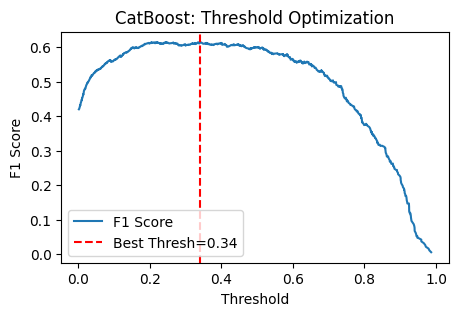

0.3417871407097925


In [9]:
# --- Threshold Tuning ---

def find_optimal_threshold(y_true, y_probs, model_name):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    max_f1 = f1_scores[best_idx]

    print(f"{model_name} -> Best Threshold: {best_thresh:.4f}, Max F1: {max_f1:.4f}")

    # Plot F1 vs Threshold

    plt.figure(figsize=(5, 3))
    plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
    plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Thresh={best_thresh:.2f}')
    plt.title(f'{model_name}: Threshold Optimization')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.savefig(f'../artifacts/images/{model_name}_threshold_tuning.png')
    plt.show()

    return best_thresh

for i, (name, model) in enumerate(best_models.items()):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"--- {name} ---")
    best_thresh = find_optimal_threshold(y_test, y_proba, name)
    print(best_thresh)
    y_pred = (y_proba >= best_thresh).astype(int)
   
# # Get Probabilities
# y_probs_dt = best_dt.predict_proba(X_test)[:, 1]
# y_probs_nn = model_best.predict(X_test_scaled).flatten()

# best_thresh_dt = find_optimal_threshold(y_test, y_probs_dt, "Decision Tree")
# best_thresh_nn = find_optimal_threshold(y_test, y_probs_nn, "Neural Network")

Logistic Regression -> Best Threshold: 0.3418, Max F1: 0.6139


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

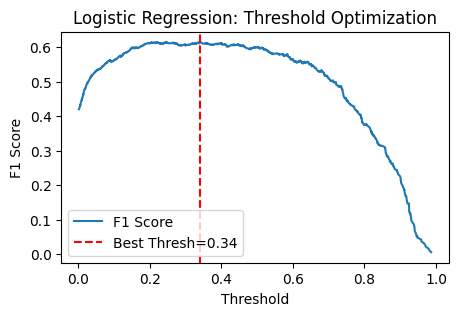

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1035
           1       0.52      0.76      0.61       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.79      0.75      0.76      1409

Decision Tree -> Best Threshold: 0.4588, Max F1: 0.6349


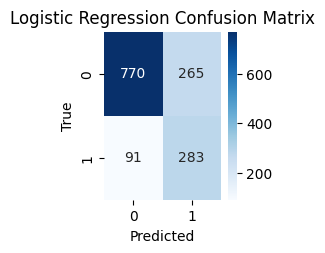

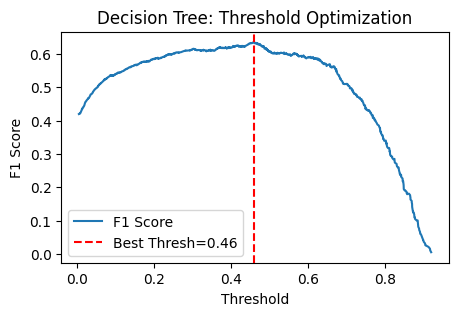

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1035
           1       0.56      0.73      0.63       374

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409

RandomForest -> Best Threshold: 0.2963, Max F1: 0.5913


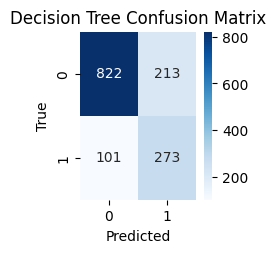

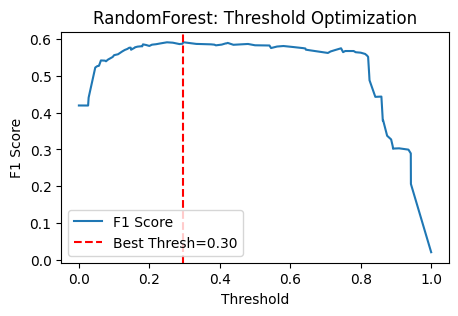

--- RandomForest ---
              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1035
           1       0.49      0.75      0.59       374

    accuracy                           0.73      1409
   macro avg       0.69      0.73      0.69      1409
weighted avg       0.78      0.73      0.74      1409

XGBoost -> Best Threshold: 0.2833, Max F1: 0.5985


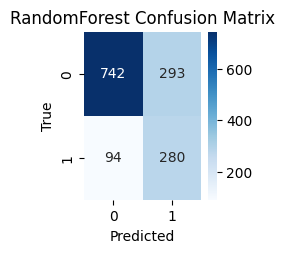

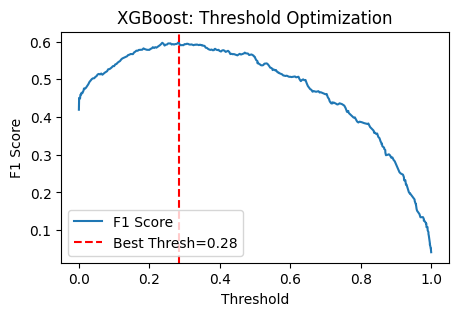

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1035
           1       0.49      0.76      0.60       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.79      0.73      0.74      1409

CatBoost -> Best Threshold: 0.2864, Max F1: 0.6125


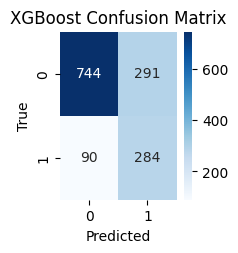

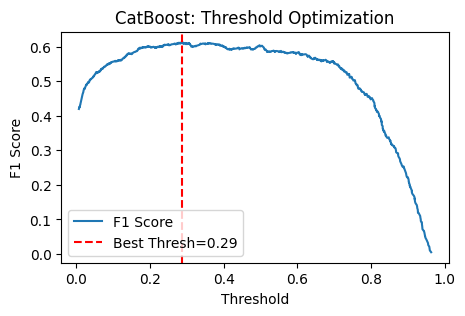

--- CatBoost ---
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.75      1409



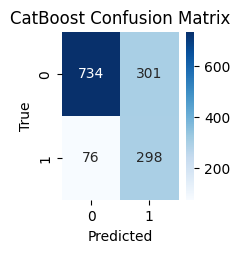

In [11]:
plt.figure(figsize=(15, 10))
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

roc_data = {}

for i, (name, model) in enumerate(best_models.items()):
    # Predictions
    # y_pred = model.predict(X_test)
    best_thresh = find_optimal_threshold(y_test, y_proba, name)
    y_pred = (y_proba >= best_thresh).astype(int)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = model.decision_function(X_test)
        # Min-max scale to 0-1 for plotting simple ROC curve approximation or just leave as is for ranking
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    ax = plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    
    # Store ROC data
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_data[name] = (fpr, tpr, auc(fpr, tpr))
    
    # Print Report
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))

plt.show()

Logistic Regression -> Best Threshold: 0.3418, Max F1: 0.6139


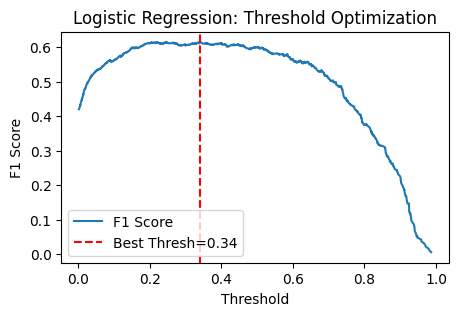


--- Logistic Regression ---
F1 Score: 0.613882863340564
Precision: 0.5164233576642335
Recall: 0.7566844919786097
Accuracy: 0.7473385379701917
Decision Tree -> Best Threshold: 0.4588, Max F1: 0.6349


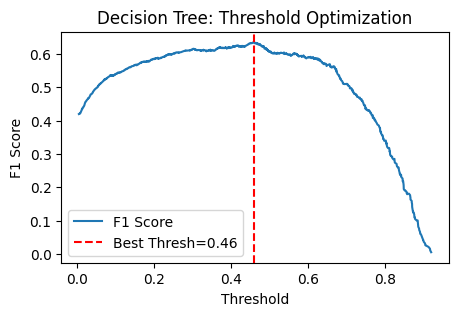


--- Decision Tree ---
F1 Score: 0.6348837209302326
Precision: 0.5617283950617284
Recall: 0.7299465240641712
Accuracy: 0.7771469127040455
RandomForest -> Best Threshold: 0.4222, Max F1: 0.5925


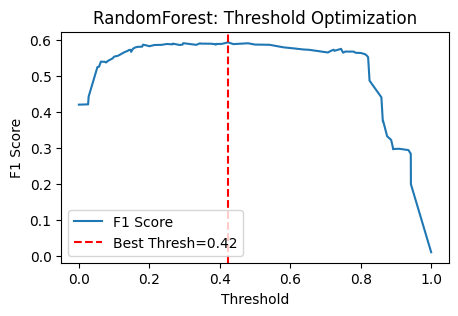


--- RandomForest ---
F1 Score: 0.5925085130533485
Precision: 0.514792899408284
Recall: 0.6978609625668449
Accuracy: 0.7452093683463449
XGBoost -> Best Threshold: 0.3067, Max F1: 0.5976


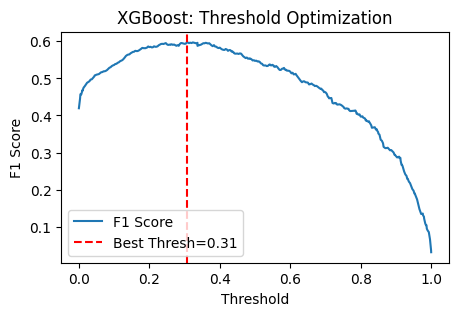


--- XGBoost ---
F1 Score: 0.597574421168688
Precision: 0.5084427767354597
Recall: 0.7245989304812834
Accuracy: 0.7409510290986515
CatBoost -> Best Threshold: 0.2864, Max F1: 0.6125


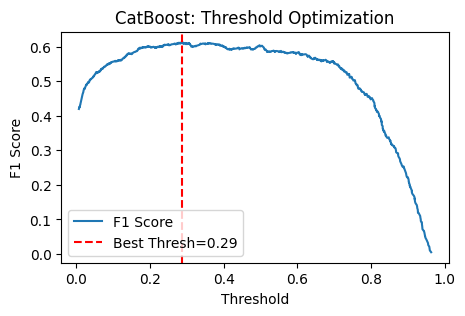


--- CatBoost ---
F1 Score: 0.6125385405960946
Precision: 0.4974958263772955
Recall: 0.7967914438502673
Accuracy: 0.7324343506032647


In [21]:
for i, (name, model) in enumerate(best_models.items()):
    # Predictions
    # y_pred = model.predict(X_test)
    best_thresh = find_optimal_threshold(y_test, y_proba, name)
    y_pred = (y_proba >= best_thresh).astype(int)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = model.decision_function(X_test)
        # Min-max scale to 0-1 for plotting simple ROC curve approximation or just leave as is for ranking
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    print(f"\n--- {name} ---")
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

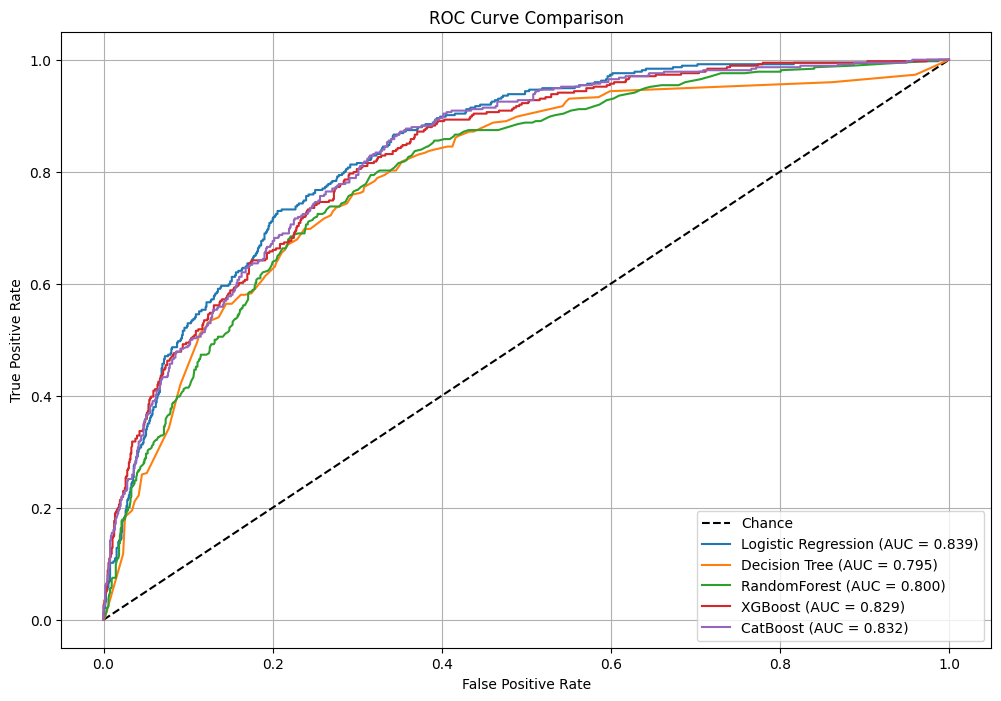

In [22]:
# ROC Curve Comparison
plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Plot individual models
for name, model in best_models.items():
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.3f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()